## Frontal view image transform

In this work we'll take the image coordinates of a square (or rectangular) object for estimate the transformation that takes the rectangle to a full on frontal view in a normalized coordinate system. To achieving this goal, we'll use the following modules:

In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import os

To convert points in homogeneous coordinates we have the following function: 

In [2]:
def make_homog(points):
      """ Convert a set of points (dim*n array) to
      homogeneous coordinates. """
      
      return np.vstack((points,np.ones((1,points.shape[1]))))

Now we can make a function to estimate the homography between matches $\mathbf{x_1}$ and $\mathbf{x_2}$. For this, first we need to condition the points by numerical stability. Then, we need to calculate the coefficients $h_{ij}$ of a matrix $\mathbf{H}$ such that:

$$
\lambda \begin{bmatrix}
x_2\\
y_2\\
1
\end{bmatrix} = 
\begin{bmatrix}
h_{11} & h_{12} & h_{13}\\
h_{21} & h_{22} & h_{23}\\
h_{31} & h_{32} & h_{33}
\end{bmatrix} \begin{bmatrix}
x_1\\
y_1\\
1
\end{bmatrix}
$$

$$
\lambda \mathbf{x_2 = Hx_1} \quad \longrightarrow \quad \mathbf{x_2 \times Hx_1 = 0}
$$

Calling $\mathbf{h_i}$ to i-th row of matrix $\mathbf{H}$ in form of a column vector, we have:

$$
\begin{bmatrix}
x_2\\
y_2\\
1
\end{bmatrix} \times \begin{bmatrix}
\mathbf{h_1^T x_1}\\
\mathbf{h_2^T x_1}\\
\mathbf{h_3^T x_1}
\end{bmatrix} = \mathbf{0} \quad \longrightarrow \quad
\begin{bmatrix}
y_2\mathbf{h_3^T x_1}-\mathbf{h_2^T x_1}\\
\mathbf{h_1^T x_1}-x_2\mathbf{h_3^T x_1}\\
x_2\mathbf{h_2^T x_1}-y_2\mathbf{h_1^T x_1}
\end{bmatrix} = \mathbf{0}
$$

$$
\begin{bmatrix}
\mathbf{0^T} & -\mathbf{x_1^T} & y_2\mathbf{x_1^T}\\
\mathbf{x_1^T} & \mathbf{0^T} & -x_2\mathbf{x_1^T}\\
-y_2\mathbf{x_1^T} & x_2\mathbf{x_1^T} & \mathbf{0^T}
\end{bmatrix}
\begin{bmatrix}
\mathbf{h_1}\\
\mathbf{h_2}\\
\mathbf{h_3}
\end{bmatrix} = \mathbf{0} \quad \longrightarrow \quad
\mathbf{Ah = 0}
$$

Where matrix $\mathbf{A}$ can be expanded with more row if there are more correspondences of points. This equation system can be solved using SVD descomposition with four matches for a minimal solution.

Finally, once we have solved the equations system can decondition the matrix $\mathbf{H}$ calculated with the conditioned points. 

With this explanation the function proposed to compute the homography is the following:

In [3]:
def H_from_points(x1, x2):
    n = len(x1.T)

    # condition points (important for numerical reasons)
    # --from points--
    m = np.mean(x1[:2], axis=1)
    maxstd = max(np.std(x1[:2], axis=1)) + 1e-9
    C1 = np.diag([1/maxstd, 1/maxstd, 1])
    C1[0][2] = -m[0]/maxstd
    C1[1][2] = -m[1]/maxstd
    x1 = np.dot(C1,x1)
    # --to points--
    m = np.mean(x2[:2], axis=1)
    maxstd = max(np.std(x2[:2], axis=1)) + 1e-9
    C2 = np.diag([1/maxstd, 1/maxstd, 1])
    C2[0][2] = -m[0]/maxstd
    C2[1][2] = -m[1]/maxstd
    x2 = np.dot(C2,x2)

    A = np.ones([3*n,9])
    zero = np.array([0,0,0])
    for i in range(n):            
        x = x1[:,i]
        A[3*i] = np.hstack([zero, -x, x2[1,i]*x])
        A[3*i+1] = np.hstack([x, zero, -x2[0,i]*x])
        A[3*i+2] = np.hstack([-x2[1,i]*x, x2[0,i]*x, zero])

    *_,Vh = np.linalg.svd(A)
    x = Vh.T[:,-1]
    H = x.reshape(3,3)

    # decondition
    H = np.dot(np.linalg.inv(C2),np.dot(H,C1))

    # normalize and return
    return H / H[2,2]

Once the homography is calculated we must apply it to an image. This task can be done with:

In [4]:
def Htransform(im, H, out_size):
    # Applies a homography transform to im
    pil_im = Image.fromarray(im)
    pil_size = out_size[1], out_size[0]
    return np.array(pil_im.transform(
        pil_size, Image.PERSPECTIVE, H.reshape(9)[0:8] / H[2,2], Image.LINEAR))

Now, with the image of a book, we'll to show the results using the functions defined above. For this example the 4 corners coordinates of book $x_1$ were acquired with ginput function and the output image coordinates $x_2$ were set in such way that it was rectangular with a size of $300 \times 400$ px.

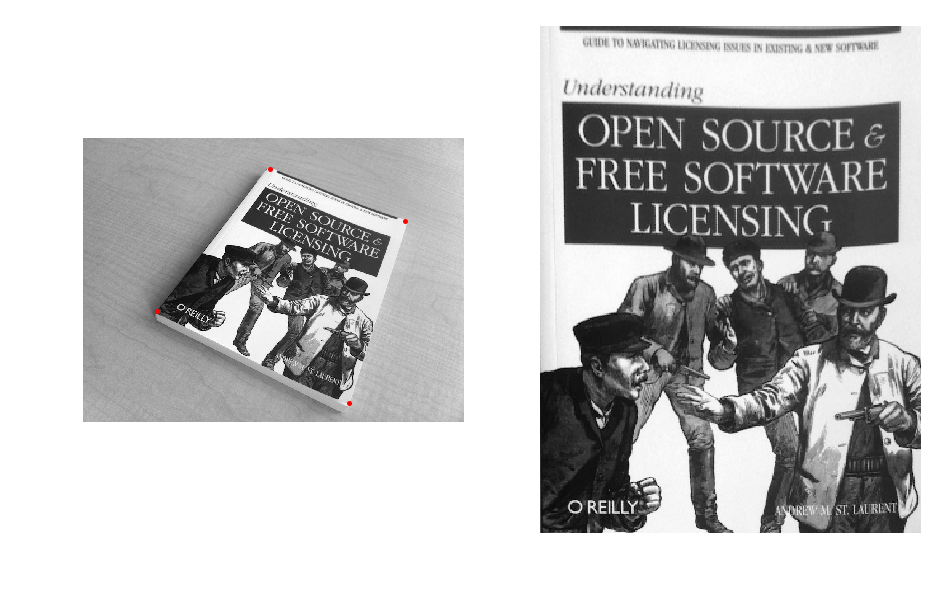

In [5]:
im1 = np.array(Image.open(os.path.abspath('data/book_perspective.jpg')).\
               convert('L'))

x1 = np.array([[ 491.34764815,  845.97495362,  193.78680563,  697.19453236],
               [82.81703591,  219.36892939,  453.74904507,  696.28151261]])

h, w = 400, 300
x2 = np.array([[0,w,0,w],[0,0,h,h]])


xh1 = make_homog(x1)
xh2 = make_homog(x2)
H = H_from_points(xh2, xh1)
im_out = Htransform(im1, H, (h,w))

plt.figure(dpi=180)
plt.subplot(121), plt.imshow(im1,cmap='gray'), plt.axis('off')
plt.plot(x1[0],x1[1],'r.',markersize=2)
plt.subplot(122), plt.imshow(im_out,cmap='gray'), plt.axis('off')
plt.show()